In [16]:
import pandas as pd
import numpy as np

# Preprocessing
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Getting the data

Recover dataset built in previous datasets

In [3]:
accidents_df = pd.read_csv('../data/processed/accidents.csv', sep=';')

/home/mayra/workspace/corvusenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,7,17,23,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
accidents_df.head()

,Unnamed: 0,ano,br,causa_acidente,classificacao_acidente,condicao_metereologica,data_inversa,delegacia,dia_semana,fase_dia,...,sentido_via,tipo_acidente,tipo_pista,tracado_via,uf,uop,uso_solo,veiculos,data,infracoes
0,0,2007,101.0,Falta de atenção,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Plena noite,...,Crescente,Saída de Pista,Simples,Cruzamento,RN,NaN,Rural,1,2007-01-01,0
1,1,2007,304.0,Outras,Com Vítimas Feridas,Ceu Claro,01/01/2007,NaN,Segunda,Plena noite,...,Crescente,Colisão com objeto móvel,Simples,Reta,RN,NaN,Rural,1,2007-01-01,0
2,2,2007,101.0,Não guardar distância de segurança,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Anoitecer,...,Crescente,Colisão traseira,Dupla,Reta,RN,NaN,Urbano,1,2007-01-01,0
3,3,2007,101.0,Ingestão de álcool,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Pleno dia,...,Decrescente,Colisão traseira,Dupla,Reta,RN,NaN,Rural,3,2007-01-01,0
4,4,2007,304.0,Não guardar distância de segurança,Sem Vítimas,Ceu Claro,01/01/2007,NaN,Segunda,Pleno dia,...,Crescente,Colisão traseira,Simples,Reta,RN,NaN,Urbano,2,2007-01-01,0


In [5]:
accidents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Data columns (total 34 columns):
Unnamed: 0                35804 non-null int64
ano                       35804 non-null object
br                        35804 non-null float64
causa_acidente            35804 non-null object
classificacao_acidente    35804 non-null object
condicao_metereologica    35804 non-null object
data_inversa              35804 non-null object
delegacia                 2865 non-null object
dia_semana                35804 non-null object
fase_dia                  35804 non-null object
feridos                   35804 non-null int64
feridos_graves            35804 non-null int64
feridos_leves             35804 non-null int64
horario                   35804 non-null object
id                        35804 non-null float64
ignorados                 35804 non-null int64
ilesos                    35804 non-null int64
km                        35804 non-null object
latitude                  2865 n

First, we remove the columns with missing data

In [6]:
accidents_cleaned_df = accidents_df.drop(labels=['latitude', 'longitude', 'uop', 'regional', 'delegacia'],
                                        axis='columns')

In [7]:
accidents_cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35804 entries, 0 to 35803
Data columns (total 29 columns):
Unnamed: 0                35804 non-null int64
ano                       35804 non-null object
br                        35804 non-null float64
causa_acidente            35804 non-null object
classificacao_acidente    35804 non-null object
condicao_metereologica    35804 non-null object
data_inversa              35804 non-null object
dia_semana                35804 non-null object
fase_dia                  35804 non-null object
feridos                   35804 non-null int64
feridos_graves            35804 non-null int64
feridos_leves             35804 non-null int64
horario                   35804 non-null object
id                        35804 non-null float64
ignorados                 35804 non-null int64
ilesos                    35804 non-null int64
km                        35804 non-null object
mortos                    35804 non-null int64
municipio                 35804 

## A fancier pre-processing

The last step before training the model is encoding the categorical data.

In [8]:
categorical = ['causa_acidente', 'fase_dia','tracado_via',
               'condicao_metereologica', 'dia_semana', 'uso_solo',
               'sentido_via', 'tipo_acidente', 'tipo_pista']
# numeric
other = list(set(accidents_cleaned_df.columns) - set(categorical))

We need to normalize the categorical data first.

In [9]:
for category in categorical + ['classificacao_acidente']:
    accidents_cleaned_df[category] = accidents_cleaned_df[category].str.strip()
    accidents_cleaned_df[category] = accidents_cleaned_df[category].str.lower()
    
accidents_cleaned_df['dia_semana'] = accidents_cleaned_df['dia_semana'].str.split('-').str.get(0)

In [10]:
enc = OneHotEncoder()
data = enc.fit_transform(accidents_cleaned_df[categorical])

# transform to df agagin
data_df = pd.DataFrame(data.toarray())
data_df.columns = [cat for arr in enc.categories_ for cat in arr]
# update cols

# add another data
data_df = accidents_cleaned_df[other].join(data_df).join(
         pd.get_dummies(accidents_cleaned_df['classificacao_acidente'],
                         prefix='class')
    ).drop(labels=['missing_value'], axis='columns', errors='ignore')

In [11]:
data_df.head()

,ano,classificacao_acidente,ignorados,municipio,id,horario,pessoas,feridos,uf,infracoes,...,saída de leito carroçável,saída de pista,tombamento,dupla,múltipla,simples,class_com vítimas fatais,class_com vítimas feridas,class_ignorado,class_sem vítimas
0,2007,sem vítimas,0,EXTREMOZ,173746.0,02:20:00,1,0,RN,0,...,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0,1
1,2007,com vítimas feridas,0,MACAIBA,173937.0,18:00:00,1,1,RN,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,1,0,0
2,2007,sem vítimas,0,SAO GONCALO DO AMARANTE,173943.0,17:30:00,2,0,RN,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1
3,2007,sem vítimas,0,PARNAMIRIM,173965.0,16:30:00,3,0,RN,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0,1
4,2007,sem vítimas,0,MOSSORO,173991.0,16:10:00,2,0,RN,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,1


In [12]:
# Remove irrelevant data
data_df.drop(labels=['id', 'horario', 'data_inversa', 'municipio', 'uf', 'Unnamed: 0', "(null)"], 
             axis='columns', inplace=True)

In [13]:
list(data_df.columns)

['ano',
 'classificacao_acidente',
 'ignorados',
 'pessoas',
 'feridos',
 'infracoes',
 'ilesos',
 'feridos_graves',
 'data',
 'br',
 'km',
 'feridos_leves',
 'veiculos',
 'mortos',
 'agressão externa',
 'animais na pista',
 'avarias e/ou desgaste excessivo no pneu',
 'carga excessiva e/ou mal acondicionada',
 'condutor dormindo',
 'defeito mecânico em veículo',
 'defeito mecânico no veículo',
 'defeito na via',
 'deficiência ou não acionamento do sistema de iluminação/sinalização do veículo',
 'desobediência à sinalização',
 'desobediência às normas de trânsito pelo condutor',
 'desobediência às normas de trânsito pelo pedestre',
 'dormindo',
 'falta de atenção',
 'falta de atenção do pedestre',
 'falta de atenção à condução',
 'fenômenos da natureza',
 'ingestão de substâncias psicoativas',
 'ingestão de álcool',
 'ingestão de álcool e/ou substâncias psicoativas pelo pedestre',
 'mal súbito',
 'não guardar distância de segurança',
 'objeto estático sobre o leito carroçável',
 'outras

# Final cleaning
Using correlation to remove some columns

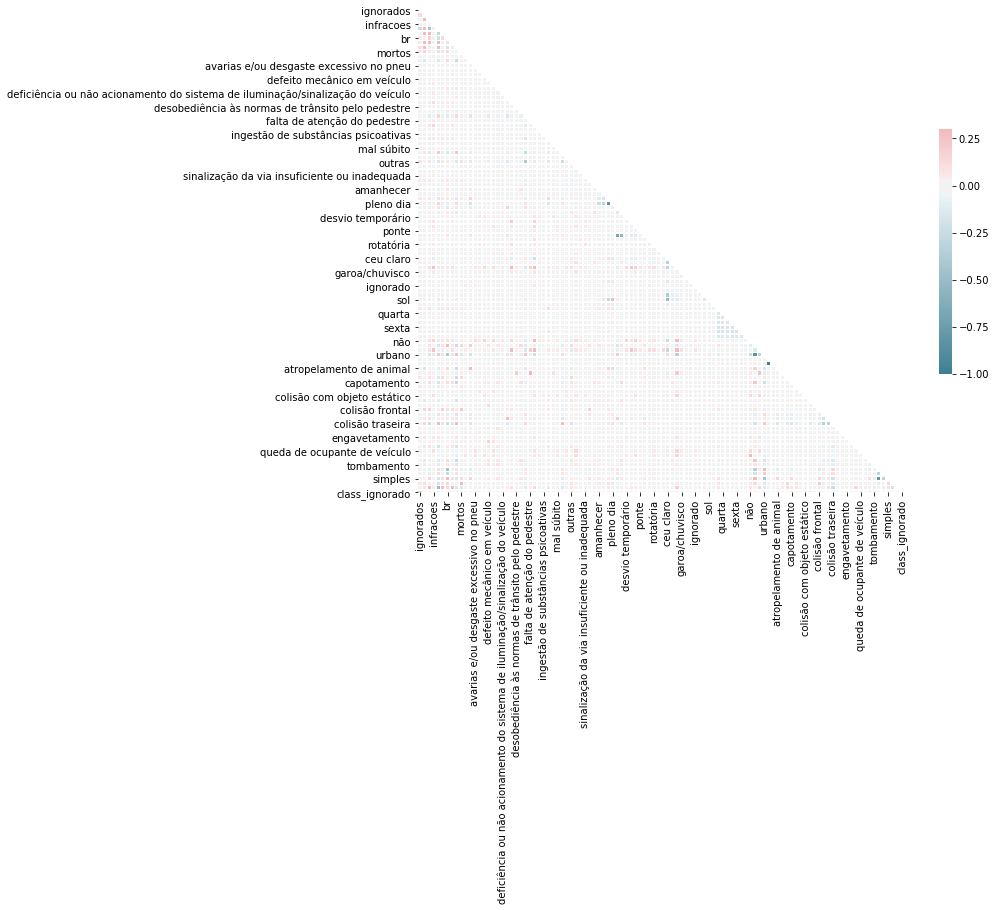

In [17]:
# Compute the correlation matrix
corr = data_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})